## Image preparation and data augmentation

This notebook processes initial images and produces several versions for each image.<br>
<ul><li>Black and white equalized images</li>
    Initial images are just converted into black&white, and histogram equalization is applied<br><br>
    <li>Cropped Black and white equalized images</li>
    The database provides cropping area information, to keep only the the doc part. Cropping is applied before equalization to avoid taking into account backgroung information in the equalization process.<br><br>
    <li>Grabcut cropped Black and white equalized images</li>
    An algoryhtm is used to remove the background before further processing happens. As the background is replaced by large black areas, this part of the image must be exluded from the hitogram equalization process.
    </ul>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join
from lxml import etree

from PIL import Image
from PIL import ImageOps as IO
import cv2

In [2]:
# Define data directories
my_data = "../data"
annotations = my_data + '/Annotation'        # BO file to be merged with additional information
images = my_data + '/Images' # SAP file with order fulfilment dates
cropped = my_data + '/Cropped'
grabcut = my_data + '/Grabcut'
bw = my_data + '/BWEqu'

### Grabcut function

This method takes an image and replaces as much as possible the background by a solid black area. The area to start the process of separation is typically the cropping area.<br>It returns not only the modified image, but also the mask which will be used in the further histogram equalization.

In [3]:
def img_grabcut(img, xmin_gc, ymin_gc, xmax_gc, ymax_gc):
    img_mode = img.mode
    np_img = np.array(img)

    mask = np.zeros(np_img.shape[:2],np.uint8)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)

    rect = (xmin_gc, ymin_gc, xmax_gc, ymax_gc)
    cv2.grabCut(np_img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img = img*mask2[:,:,np.newaxis]
    
    return Image.fromarray(img, img_mode), Image.fromarray(mask2, 'L')

Several processes can be applied to a picture using this method:<ul><li>Grabcut to remove the background</li><li>Cropping to reduce the picture to the useful area</li><li>Grayscale data conversion</li><li>Histogram equalization</li></ul>

In [4]:
def process_pictures(outfolder, crop = False, grabcut=False, grayscale=True, equalize = True):
# Convert all pictures into cropped and autocontrasted version
    # Explore all picture folders
    folders = [f for f in listdir(annotations) if (~isfile(join(annotations, f)) &
                                                    f.lower().startswith('n02'))]

    for folder in folders:
        print(folder)
        current_folder = join(annotations, folder)
        files = [f for f in listdir(current_folder) if (isfile(join(current_folder, f)))]
        for file in files:
            # Read each picture
            current_file = join(current_folder, file)      
            picture_file = join(images, folder, file + '.jpg')
            img = Image.open(picture_file) 

            # Get crop region for each picture
            tree = etree.parse(current_file)
            for coord in tree.xpath("/annotation/object/bndbox"):
                xmin_el = int(coord.xpath("xmin")[0].text)
                xmax_el = int(coord.xpath("xmax")[0].text)
                ymin_el = int(coord.xpath("ymin")[0].text)
                ymax_el = int(coord.xpath("ymax")[0].text)
                xmin_gc = xmin_el
                xmax_gc = xmax_el
                ymin_gc = ymin_el
                ymax_gc = ymax_el
            
            if crop and grabcut:
                xmin_el = max(xmin_el - 5, 0)
                xmax_el = min(xmax_el + 5, int(img.size[0]))
                ymin_el = max(ymin_el - 5, 0)
                ymax_el = min(ymax_el + 5, int(img.size[1]))

            if grabcut:
                try:
                    img, mask = img_grabcut(img, xmin_gc, ymin_gc, xmax_gc, ymax_gc)
                    if equalize:
                        pass
                        img = IO.equalize(img, mask)
                except:
                    pass

            if crop:
                img = img.crop((xmin_el,ymin_el,xmax_el,ymax_el))             

            try:
                if equalize and  not grabcut:
                    img = IO.equalize(img)
                    
                if grayscale:
                    img = IO.grayscale(img)

                # img_cropped = IO.autocontrast(img_cropped, 1)
            except:
                pass

            out_picture_file = join(outfolder, folder, file + '.jpg')
            img.save(out_picture_file)


In [5]:
# Greate a grapcut, cropped, grayscale and equalized version of all images
process_pictures(grabcut, crop = True, grabcut=True, grayscale=True, equalize = True)

n02085620-Chihuahua
n02085782-Japanese_spaniel
n02085936-Maltese_dog
n02086079-Pekinese
n02086240-Shih-Tzu
n02086646-Blenheim_spaniel
n02086910-papillon
n02087046-toy_terrier
n02087394-Rhodesian_ridgeback
n02088094-Afghan_hound
n02088238-basset
n02088364-beagle
n02088466-bloodhound
n02088632-bluetick
n02089078-black-and-tan_coonhound
n02089867-Walker_hound
n02089973-English_foxhound
n02090379-redbone
n02090622-borzoi
n02090721-Irish_wolfhound
n02091032-Italian_greyhound
n02091134-whippet
n02091244-Ibizan_hound
n02091467-Norwegian_elkhound
n02091635-otterhound
n02091831-Saluki
n02092002-Scottish_deerhound
n02092339-Weimaraner
n02093256-Staffordshire_bullterrier
n02093428-American_Staffordshire_terrier
n02093647-Bedlington_terrier
n02093754-Border_terrier
n02093859-Kerry_blue_terrier
n02093991-Irish_terrier
n02094114-Norfolk_terrier
n02094258-Norwich_terrier
n02094433-Yorkshire_terrier
n02095314-wire-haired_fox_terrier
n02095570-Lakeland_terrier
n02095889-Sealyham_terrier
n02096051-Aired

In [6]:
# Create a grayscale and equalized version of all images
process_pictures(bw, crop = False, grabcut=False, grayscale=True, equalize = True)

n02085620-Chihuahua
n02085782-Japanese_spaniel
n02085936-Maltese_dog
n02086079-Pekinese
n02086240-Shih-Tzu
n02086646-Blenheim_spaniel
n02086910-papillon
n02087046-toy_terrier
n02087394-Rhodesian_ridgeback
n02088094-Afghan_hound
n02088238-basset
n02088364-beagle
n02088466-bloodhound
n02088632-bluetick
n02089078-black-and-tan_coonhound
n02089867-Walker_hound
n02089973-English_foxhound
n02090379-redbone
n02090622-borzoi
n02090721-Irish_wolfhound
n02091032-Italian_greyhound
n02091134-whippet
n02091244-Ibizan_hound
n02091467-Norwegian_elkhound
n02091635-otterhound
n02091831-Saluki
n02092002-Scottish_deerhound
n02092339-Weimaraner
n02093256-Staffordshire_bullterrier
n02093428-American_Staffordshire_terrier
n02093647-Bedlington_terrier
n02093754-Border_terrier
n02093859-Kerry_blue_terrier
n02093991-Irish_terrier
n02094114-Norfolk_terrier
n02094258-Norwich_terrier
n02094433-Yorkshire_terrier
n02095314-wire-haired_fox_terrier
n02095570-Lakeland_terrier
n02095889-Sealyham_terrier
n02096051-Aired

In [7]:
# Create a cropped, grayscale and equalized version of all images
process_pictures(cropped, crop = True, grabcut=False, grayscale=True, equalize = True)

n02085620-Chihuahua
n02085782-Japanese_spaniel
n02085936-Maltese_dog
n02086079-Pekinese
n02086240-Shih-Tzu
n02086646-Blenheim_spaniel
n02086910-papillon
n02087046-toy_terrier
n02087394-Rhodesian_ridgeback
n02088094-Afghan_hound
n02088238-basset
n02088364-beagle
n02088466-bloodhound
n02088632-bluetick
n02089078-black-and-tan_coonhound
n02089867-Walker_hound
n02089973-English_foxhound
n02090379-redbone
n02090622-borzoi
n02090721-Irish_wolfhound
n02091032-Italian_greyhound
n02091134-whippet
n02091244-Ibizan_hound
n02091467-Norwegian_elkhound
n02091635-otterhound
n02091831-Saluki
n02092002-Scottish_deerhound
n02092339-Weimaraner
n02093256-Staffordshire_bullterrier
n02093428-American_Staffordshire_terrier
n02093647-Bedlington_terrier
n02093754-Border_terrier
n02093859-Kerry_blue_terrier
n02093991-Irish_terrier
n02094114-Norfolk_terrier
n02094258-Norwich_terrier
n02094433-Yorkshire_terrier
n02095314-wire-haired_fox_terrier
n02095570-Lakeland_terrier
n02095889-Sealyham_terrier
n02096051-Aired

In [8]:
# List number of pictures per folder

folders = [f for f in listdir(annotations) if (~isfile(join(annotations, f)) &
                                                f.lower().startswith('n02'))]

for folder in folders:
    current_folder = join(annotations, folder)
    files = [f for f in listdir(current_folder) if (isfile(join(current_folder, f)))]
    print("{0} images for {1}".format(len(files), folder))
    

152 images for n02085620-Chihuahua
185 images for n02085782-Japanese_spaniel
252 images for n02085936-Maltese_dog
149 images for n02086079-Pekinese
214 images for n02086240-Shih-Tzu
188 images for n02086646-Blenheim_spaniel
196 images for n02086910-papillon
172 images for n02087046-toy_terrier
172 images for n02087394-Rhodesian_ridgeback
239 images for n02088094-Afghan_hound
175 images for n02088238-basset
195 images for n02088364-beagle
187 images for n02088466-bloodhound
171 images for n02088632-bluetick
159 images for n02089078-black-and-tan_coonhound
153 images for n02089867-Walker_hound
157 images for n02089973-English_foxhound
148 images for n02090379-redbone
151 images for n02090622-borzoi
218 images for n02090721-Irish_wolfhound
182 images for n02091032-Italian_greyhound
187 images for n02091134-whippet
188 images for n02091244-Ibizan_hound
196 images for n02091467-Norwegian_elkhound
151 images for n02091635-otterhound
200 images for n02091831-Saluki
232 images for n02092002-Sc

In [9]:
def gen_sift_features(gray_img):
    sift = cv2.xfeatures2d.SIFT_create()
    # kp is the keypoints
    #
    # desc is the SIFT descriptors, they're 128-dimensional vectors
    # that we can use for our final features
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc

def show_sift_features(gray_img, color_img, kp):
    plt.imshow(cv2.drawKeypoints(gray_img, kp, color_img.copy()))

def load_img(variant, img_folder, img_file):
    picture_file = join(variant, img_folder, img_file)
    # img = Image.open(picture_file)
    img = cv2.imread(picture_file)
    img_sift = np.array(img)
    return img_sift

In [12]:
folder = "n02085782-Japanese_spaniel"
dog_file = "n02085782_1085.jpg"
dog_file = "n02085782_1143.jpg"
dog_file = "n02085782_1401.jpg"
#dog_file = "n02085782_4698.jpg"

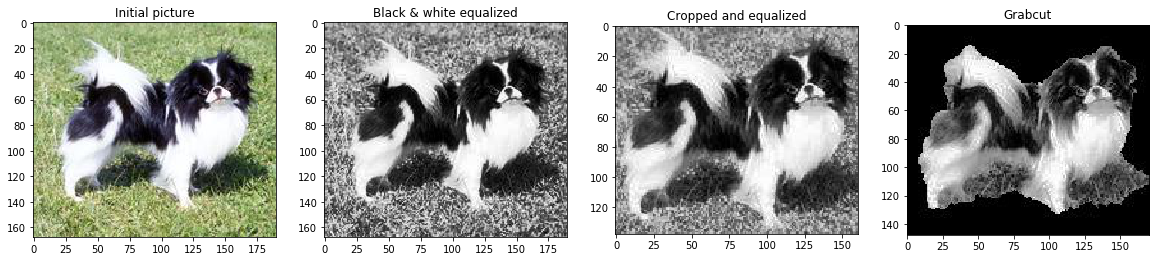

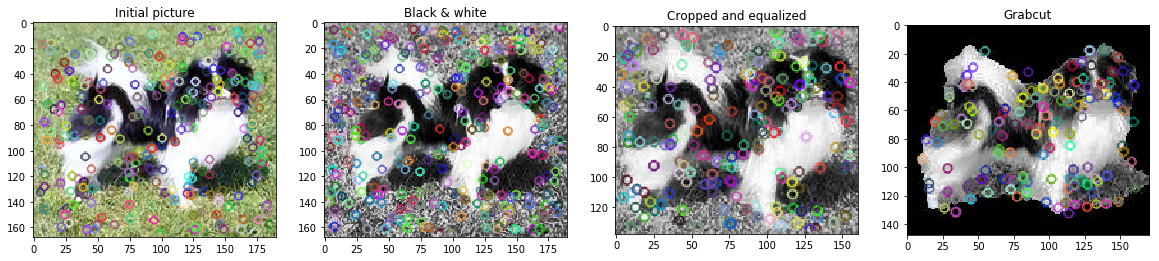

In [13]:
# Result of processed images

fig = plt.figure(figsize=(20, 4))

dog_img1 = load_img(images, folder, dog_file)
dog_img1 = cv2.cvtColor(dog_img1,cv2.COLOR_BGR2RGB)
ax1 = fig.add_subplot(1,4,1)
ax1.set_title('Initial picture')
ax1.imshow(dog_img1)


dog_img2 = load_img(bw, folder, dog_file)
ax2 = fig.add_subplot(1,4,2)
ax2.set_title('Black & white equalized')
ax2.imshow(dog_img2)


dog_img3 = load_img(cropped, folder, dog_file)
ax2 = fig.add_subplot(1,4,3)
ax2.set_title('Cropped and equalized')
plt.imshow(dog_img3)


dog_img4 = load_img(grabcut, folder, dog_file)
ax2 = fig.add_subplot(1,4,4)
ax2.set_title('Grabcut')
plt.imshow(dog_img4)
plt.show()

# Result of processed images with SIFT features

fig = plt.figure(figsize=(20, 4))

dog_img1 = load_img(images, folder, dog_file)
dog_img1 = cv2.cvtColor(dog_img1,cv2.COLOR_BGR2RGB)
ax1 = fig.add_subplot(1,4,1)
ax1.set_title('Initial picture')
dog1_kp, dog1_desc = gen_sift_features(dog_img1)
show_sift_features(dog_img1, dog1_desc, dog1_kp)

dog_img2 = load_img(bw, folder, dog_file)
ax2 = fig.add_subplot(1,4,2)
ax2.set_title('Black & white')
dog2_kp, dog2_desc = gen_sift_features(dog_img2)
show_sift_features(dog_img2, dog2_desc, dog2_kp)


dog_img3 = load_img(cropped, folder, dog_file)
ax2 = fig.add_subplot(1,4,3)
ax2.set_title('Cropped and equalized')
dog3_kp, dog3_desc = gen_sift_features(dog_img3)
show_sift_features(dog_img3, dog3_desc, dog3_kp)


dog_img4 = load_img(grabcut, folder, dog_file)
ax2 = fig.add_subplot(1,4,4)
ax2.set_title('Grabcut')
dog4_kp, dog4_desc = gen_sift_features(dog_img4)
show_sift_features(dog_img4, dog4_desc, dog4_kp)

plt.show()

